<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/pressure_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pressure control


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
This notebook investigates pressure control implementations in water distribution networks. We present operational data for the following pressure control schemes:
- Fixed outlet
- Time-based
- Flow modulation

We also implement code to derive a flow modulation curve from operational data. Finally, a model-based optimal control problem is formulated and solved using a state-of-the-art nonlinear solver. The problem formulation relies on the steady-state hydraulic conservation equations introduced earlier in this module.

First, we clone the GitHub repository and install dependencies (only run this once).

In [20]:
# run this cell once
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install wntr
  !apt-get install libsuitesparse-dev && pip install scikit-sparse
  # !pip install -q pyomo
  # !pip install --upgrade idaes-pse
  # !idaes get-extensions

fatal: destination path 'CIVE_70019_70057' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.10.1+dfsg-4build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [21]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

### Load and visualise operational data

Three 'data.npy' files are provided in the module repository's data directory.

In [34]:
# load operational data
if 'google.colab' in sys.modules:
    data_dir = '/content/CIVE_70019_70057/data/pressure_control/' # if run in Google Colab
else:
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/pressure_control/' # replace with local directory

# change to view different pressure control schemes
data_name = 'data_2.npy' # data_1.npy; data_2.npy; data_3.npy

data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()

Code to visualise operational data.

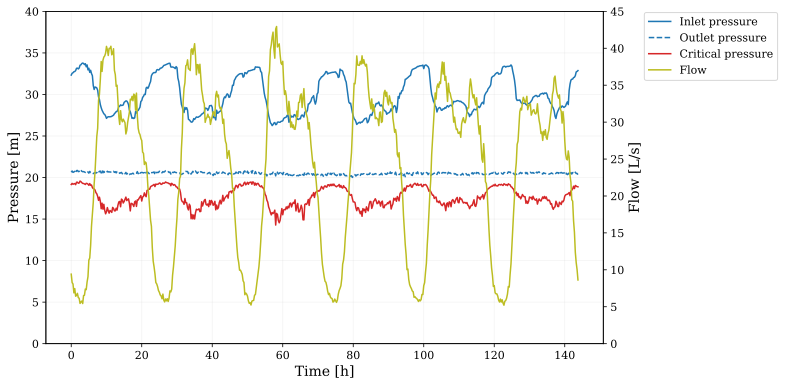

In [35]:
# make time data
time = [num / 4 for num in range(len(data['p_in']))]

# font style
plt.rcParams["font.family"] = "serif"

# create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# plot pressure on the primary y-axis
plt1 = ax1.plot(time, data['p_in'], '-', color='tab:blue')
plt2 = ax1.plot(time, data['p_out'], '--', color='tab:blue')
plt3 = ax1.plot(time, data['p_critical'], '-', color='tab:red')

# ax1.set_ylim([0, 60])
ax1.set_ylim([0, 40])
ax1.set_ylabel('Pressure [m]', fontsize=14)
ax1.set_xlabel('Time [h]', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.grid(alpha=0.15)

# Plot flow on the secondary y-axis
ax2 = ax1.twinx()
plt4 = ax2.plot(time, data['flow'], '-', color='tab:olive')
# ax2.set_ylim([0, 30])
ax2.set_ylim([0, 45])
ax2.set_ylabel('Flow [L/s]', fontsize=14)
ax2.tick_params(axis='y', which='major', labelsize=11)

# Legend code
fig.legend([plt1, plt2, plt3, plt4], labels=['Inlet pressure', 'Outlet pressure', 'Critical pressure', 'Flow'], bbox_to_anchor=(1.15, 0.89), fontsize=11)

Plot each data set and comment on the corresponding pressure control scheme (e.g. no control, fixed outlet, time-based, or flow modulation). What observations led you to these conclusions?

<font color="red">Enter response here...

### Flow modulation curve

Load and organise operational data.

In [5]:
# load operational data (use data_1.npy)
if 'google.colab' in sys.modules:
    data_dir = '/content/CIVE_70019_70057/data/pressure_control/' # if run in Google Colab
else:
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/pressure_control/' # replace with local directory

data_name = 'data_1.npy'

data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()

# assign variables
inlet_pressure = data['p_in']
outlet_pressure = data['p_out']
critical_pressure = data['p_critical']
flow = data['flow']
outlet_elev = data['outlet_elev']
critical_elev = data['critical_elev']

Compute head loss across simplified 'single pipe' system from the pressure
control valve (PCV) outlet to the critical point (CP), as follows


$$ h_f = (p_{\text{out}} + \zeta_{\text{out}}) - (p_{\text{crit}} + \zeta_{\text{crit}}),$$

where $p$ is the pressure head and $\zeta$ is the elevation head.

In [6]:
# compute head loss between pressure control valve and critical point
hf = (outlet_pressure + outlet_elev) - (critical_pressure + critical_elev)

Plot head loss - flow relationship.

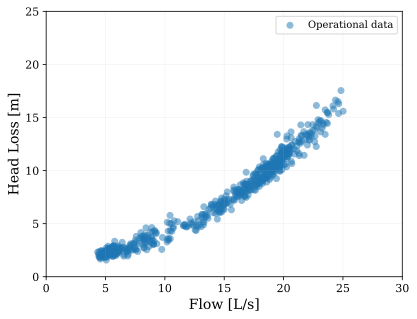

In [7]:
# Plotting code
plt.figure()

plt.scatter(flow, hf, marker='o', label='Operational data', s=50, alpha=0.5, edgecolor='none', facecolor='tab:blue')
plt.xlabel('Flow [L/s]', fontsize=14)
plt.ylabel('Head Loss [m]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.xlim([0, 30])
plt.ylim([0, 25])
plt.grid(alpha=0.15)
plt.legend()

Derive flow modulation control curve.

In [8]:
# offset minimum regulatory pressure (e.g., 15 m) and elevation difference
p_min = 15 # adjust accordingly
outlet_control = hf + p_min + (critical_elev - outlet_elev)

# reshape them to 1D arrays
flow = flow.ravel()
outlet_control = outlet_control.ravel()

# polynomial curve fitting
coeff = np.polyfit(flow, outlet_control, 2)

# generate curve using the fitted coefficients
flow_min = min(flow)
flow_max = max(flow)
fm_curve_size = int((round(flow_max) + 10) * 4 + 1) # additional step for lower bound
fm_curve_step = (round(flow_max) + 10) / fm_curve_size
x = np.arange(0, fm_curve_size) * fm_curve_step

fm_curve = np.zeros((len(x), 2))
fm_curve[:, 0] = x
fm_curve[:, 1] = np.polyval(coeff, x)

# set lower bound outlet pressure
fm_curve[0, 1] = 35
fm_curve[1, 0] = 0

Plot flow modulation curve.

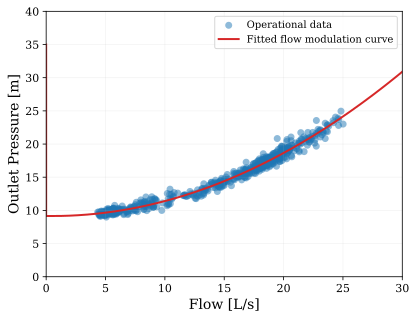

In [9]:
# plotting code
plt.figure()

plt.scatter(flow, outlet_control, marker='o', s=50, alpha=0.5, edgecolor='none', facecolor='tab:blue')
plt.plot(fm_curve[:, 0], fm_curve[:, 1], '-', color='tab:red', linewidth=2)
plt.xlabel('Flow [L/s]', fontsize=14)
plt.ylabel('Outlet Pressure [m]', fontsize=14)
plt.xlim([0, 30])
plt.ylim([0, 40])
plt.grid(alpha=0.15)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.legend(['Operational data', 'Fitted flow modulation curve'])

#### Interpretation of flow modulation curve

Discussion questions:


*   What causes the general curvature in the control profile? Would you expect this to change for different network conditions?
*   Should there be any concern with the derived outlet pressures being below the regulatory minimum of 15 m? Why or why not?
*   What may the general reasoning be behind the lower bound pressure outlet value? Why may this be necessary?

### Model-based optimal pressure control

In this section, we introduce a model-based optimal pressure control scheme. In particular, we seek to minimise the average zone pressure (AZP) of the network. The following code walks through the problem formulation and implementation of a state-of-the-art solver to solve the nonlinear optimisation problem.

**References**:
- Wright, R., Abraham, E., Parpas, P., & Stoianov, I. (2015). 'Control of water distribution networks with dynamic dma topology using strictly feasible sequential convex programming.' Water Resources Research 51(12), 9925–9941, doi: 10.1002/2015WR017466.
- Jenks, B., Ulusoy, A. J., Pecci, F., & Stoianov, I. (2023). 'Dynamically adaptive networks for integrating optimal pressure management and self-cleaning controls.' Annual Reviews in Control 55, 486-497, doi: 10.1016/j.arcontrol.2023.03.014.

#### AZP objective function:

\begin{equation*}
  \text{AZP}(x) := \frac{1}{n_t} \sum_{t=1}^{n_t} \sum_{i=1}^{n_n} w_i (h_{it} - \zeta_i),
\end{equation*}

where $h_{it}$ is the hydraulic head computed at node $i$ at time step $t$; $\zeta_i$ is the elevation of node $i$; and $w_i$ is a coefficient weighting node $i$ by the length of its connected links. That is,

\begin{equation}
        w_i = \bar{L}^{-1} \sum_{k \in \mathcal{I}_i} \frac{L_i}{2},
\end{equation}

where $\mathcal{I}_i$ is the set of links incident to node $i$; $\bar{L} = \sum_{j=1}^{n_p} L_j$; and $L \in \mathbb{R}^{n_p}$ is the vector of pipe lengths. As described in the hydraulic modelling notebook, $n_n$, $n_p$, and $n_t$ denote the number of model nodes, links, and hydraulic time steps, respectively.

#### Hydraulic constraints

Optimal valve settings for minimising of AZP must be hydraulically feasible. That is, hydraulic states of **flow** across links and **hydraulic head** at nodes must statisfy the energy and mass conservation equations introduced previously. We make one modification to the energy conservation equation to account for additional local losses across pressure control valves (PCVs). This term, $\eta$, is a decision variable in our optimisation problem. The energy and mass conservation equations are then written for all time steps $t \in \{1, \dots, n_t\}$ as

\begin{equation}
    A_{11}(q_t)q_t + A_{12}h_t + A_{10}h_{0t} + A_{13}\eta_t = 0 \\
    A_{12}^{T}q_t + d_t = 0,
\end{equation}

where
- $q_t \in \mathbb{R}^{n_p}$ is a vector of link flows
- $h_t \in \mathbb{R}^{n_n}$ is a vector of nodal heads
- $\eta_t \in \mathbb{R}^{n_v}$ is a vector of local losses across $n_v$ PCV links
- $A_{11} \in \mathbb{R}^{n_p \times n_p} = k_j|q_j^{n-1}|, \;\, \forall j \in \{1, \dots, n_p\}$ is a diagonal matrix of frictional head losses and $k_j$ is the pipe or valve resistance coefficient
- $A_{12} \in \mathbb{R}^{n_p \times n_n}$ is the link-node incidence matrix
- $A_{10} \in \mathbb{R}^{n_p \times n_0}$ is the link-known head incidence matrix
- $A_{13} \in \mathbb{R}^{n_p \times n_v}$ maps PCV locations which correspond to a local loss $\eta_t$
- $d_t \in \mathbb{R}^{n_n}$ is a vector of known demands (i.e. loading conditions)
- $h_{0t} \in \mathbb{R}^{n_0}$ is a vector of known hydraulic heads (i.e. boundary conditions)
- $\zeta \in \mathbb{R}^{n_n}$ is the vector of nodal elevations

In addition, we enforce bounds on continuous state and control variables. The first is a minimum hydraulic head constraint

\begin{equation*}
  h_t \geq h^{\min}, \quad \forall t \in \{1, \dots, n_t\}
\end{equation*}

where $h^{\min} \in \mathbb{R}^{n_n}$ corresponds to a minimum regulatory pressure (e.g. 15 m) + elevation head $\zeta$.

We also introduce bounds on the direction of flow $q_t$ and $\eta_t$ across PCV links at each time step $t$. In this problem, we define known PCV links to operate in the positive flow direction. Therefore,

\begin{alignat}{3}
  &A_{13}^Tq_t \geq 0, \quad \forall t \in \{1, \dots, n_t\} \\
  &\eta_t \geq 0, \quad \forall t \in \{1, \dots, n_t\}
\end{alignat}

#### Problem formulation

We denote the continuous decision variables in our AZP optimisation problem as $x_t := [q_t^T, h_t^T, \eta_t^T]^T$, for all $t \in \{1, \dots, n_t\}$. The AZP optimisation problem is formulated as

\begin{alignat}{3}
  & \underset{\substack{x}}{\text{minimize}}
  & \quad & \frac{1}{n_t} \sum_{t=1}^{n_t} \sum_{i=1}^{n_n} w_i (h_{it} - \zeta_i) \\
  & \text{subject to}
  & & A_{11}(q_t)q_t + A_{12}h_t + A_{10}h_{0t} + A_{13}\eta_t = 0, \quad \forall t \in \{1,\dots,n_t\} \\
  & & & A_{12}^{T}q_t + d_t = 0, \quad \forall t \in \{1,\dots,n_t\} \\
  & & & x_t \in X_t, \quad \forall t \in \{1,\dots,n_t\}
\end{alignat}

where set $\mathcal{X}$ collects the previously defined bounds on continuous variables.

#### Code implementation

Import previously defined functions in hydraulic modelling notebook.

In [10]:
# # load functions from src folder
# if 'google.colab' in sys.modules:
#     sys.path.append('/content/CIVE_70019_70057/src/')
#     from general_functions import *
#     from hydraulic_functions import *
# else:
#     sys.path.append('/home/bradw/workspace/CIVE_70019_70057/src/')
#     from general_functions import *
#     from hydraulic_functions import *

Load network data.

In [11]:
# # load network data

# # net_name = 'demo.inp'
# # pcv_name = ['L1']

# # net_name = 'pescara.inp'
# # pcv_name = ['54', '11', '89', '90']

# net_name = 'stkl_control.inp'
# pcv_name = ['link_1837']

# # load network data
# if 'google.colab' in sys.modules:
#     net_dir = '/content/CIVE_70019_70057/data/networks/' # if run in google colab
# else:
#     net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/' # change local directory

# wdn = load_network_data(os.path.join(net_dir, net_name))

Set PCV link location.

In [12]:
# # extract element names
# pipe_names = wdn.net_info['pipe_names']
# junction_names = wdn.net_info['junction_names']

# # find indices of pcv_links and corresponding downstream nodes
# pcv_loc = [i for i, name in enumerate(pipe_names) if name in pcv_name]
# pcv_nodes = wdn.link_df.loc[pcv_loc, 'node_in'].tolist()

Plot network.

In [13]:
# plot_network(wdn, pcv_nodes=pcv_nodes)

Create optimisation problem parameters.

In [14]:
# from scipy.sparse import csr_matrix

# # unload variables
# A12 = wdn.A12
# A10 = wdn.A10
# net_info = wdn.net_info
# link_df = wdn.link_df
# node_df = wdn.node_df
# demand_df = wdn.demand_df
# h0_df = wdn.h0_df

# L = link_df['length'].values.astype(float).reshape(-1, 1)
# elev = node_df.loc[node_df['node_ID'].isin(net_info['junction_names']), 'elev'].astype(float).to_numpy().reshape(-1, 1)
# d = demand_df.iloc[:, 1:].astype(float).to_numpy()
# h0 = h0_df.iloc[:, 1:].astype(float).to_numpy()

# # make A13 matrix (pcv mapping)
# A13 = np.zeros([net_info['np'], len(pcv_loc)])
# for idx, loc in enumerate(pcv_loc):
#     A13[loc, idx] = 1
# A13 = csr_matrix(A13)

# # head loss model parameters
# K = np.zeros((net_info['np'], 1))
# for idx, row in link_df.iterrows():
#     if row['link_type'] == 'pipe':
#         K[idx] = friction_loss(net_info, row)

#     elif row['link_type'] == 'valve':
#         K[idx] = local_loss(row)

# n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)

# # node and link maps
# nodes_map = {i: np.where(A12.toarray()[i, :] != 0) for i in range(0, net_info['np'])}
# sources_map = {i: np.where(A10.toarray()[i, :] != 0) for i in range(0, net_info['np'])}
# links_map = {i: np.where(A12.T.toarray()[i, :] != 0) for i in range(0, net_info['nn'])}

# # initialise continuous variables
# q_df, h_df = hydraulic_solver(wdn, method='nr_schur') # no control hydraulics
# q_0 = q_df.iloc[:, 1:].to_numpy()
# h_0 = h_df.iloc[:, 1:].to_numpy()

# eta_0 = np.zeros([len(pcv_loc), net_info['nt']])

# # AZP weights (w)
# w = np.abs(A12.T) * np.array(L) / 2
# azp_weights = w / np.sum(w)

# # h and q variable bounds
# p_min = 15 # minimum pressure head
# h_min = elev * np.ones([1, net_info['nt']])
# h_min[d > 0] += p_min
# h_max = np.ones([net_info['nn'], 1]) * np.max(np.vstack((h0, h_0)))
# h_max = np.tile(h_max, (1, net_info['nt']))

# q_min = -100 * np.ones([net_info['np'], net_info['nt']])
# q_max = 100 * np.ones([net_info['np'], net_info['nt']])

# # eta variable bounds
# A = np.hstack([A12.toarray(), A10.toarray()])
# all_h_min = np.vstack([h_min, h0])
# all_h_max = np.vstack([h_max, h0])

# eta_min = np.zeros([net_info['np'], net_info['nt']])
# eta_max = np.zeros([net_info['np'], net_info['nt']])

# for link in range(net_info['np']):
#     out_node = np.where(A[link, :] == -1)[0]
#     in_node = np.where(A[link, :] == 1)[0]

#     eta_min[link, :] = all_h_min[out_node[0], :] - all_h_max[in_node[0], :]
#     eta_max[link, :] = all_h_max[out_node[0], :] - all_h_min[in_node[0], :]

# eta_min = eta_min[pcv_loc, :]
# eta_max = eta_max[pcv_loc, :]

# # enforce q and eta bounds at PCV links
# q_min[pcv_loc, :] = 0
# eta_min[:] = 0

Formulate `Pyomo` model. Note that `Pyomo` is a general purpose modelling language for formulating optimisation problems in Python.

In [15]:
# from pyomo.environ import *
# import idaes

# # create a Pyomo Concrete Model
# model = ConcreteModel()

# # define index sets
# model.i_set = RangeSet(0, net_info['nn'] - 1)
# model.j_set = RangeSet(0, net_info['np'] - 1)
# model.k_set = RangeSet(0, net_info['nt'] - 1)
# model.n_set = RangeSet(0, len(pcv_loc) - 1)
# model.s_set = RangeSet(0, A10.shape[1] - 1)

# # define function for variable bounds
# def bounds_h(model, i, k):
#     return (h_min[i, k], h_max[i, k])
# def bounds_q(model, j, k):
#     return (q_min[j, k], q_max[j, k])
# def bounds_eta(model, n, k):
#     return (eta_min[n, k], eta_max[n, k])

# # create dictionaries of initial values
# q_0_dict = {(j, k): q_0[j, k] for j in model.j_set for k in model.k_set}
# h_0_dict = {(i, k): h_0[i, k] for i in model.i_set for k in model.k_set}
# eta_0_dict = {(n, k): eta_0[n, k] for n in model.n_set for k in model.k_set}

# # define variables
# model.q = Var(model.j_set, model.k_set, bounds=bounds_q, initialize=q_0_dict)
# model.h = Var(model.i_set, model.k_set, bounds=bounds_h, initialize=h_0_dict)
# model.eta = Var(model.n_set, model.k_set, bounds=bounds_eta, initialize=eta_0_dict)

# # energy conservation constraint
# def energy_constraint_rule(model, j, k):
#     return (
#         K[j] * (model.q[j, k]) * abs(model.q[j, k])**(n_exp[j] - 1)
#         + sum(A12[j, i] * model.h[i, k] for i in nodes_map[j][0])
#         + sum(A10[j, s] * h0[s, k] for s in sources_map[j][0])
#         + sum(A13[j, n] * model.eta[n, k] for n in model.n_set) == 0
#     )

# model.energy_constraints = Constraint(model.j_set, model.k_set, rule=energy_constraint_rule)

# # mass conservation constraint
# def mass_constraint_rule(model, i, k):
#     return (sum(A12.T[i, j] * model.q[j, k] for j in links_map[i][0]) == d[i, k])

# model.mass_constraints = Constraint(model.i_set, model.k_set, rule=mass_constraint_rule)

# # objective function
# def objective_rule(model):
#     return (
#         (1 / net_info['nt']) * sum(sum(azp_weights[i] * (model.h[i, k] - elev[i]) for i in model.i_set) for k in model.k_set)
#     )

# model.objective = Objective(rule=objective_rule, sense=minimize)

# results = SolverFactory('ipopt').solve(model, tee=True)

Format and save optimal pressure control results.

In [16]:
# # save q values
# q_sol = np.reshape([value(model.q[i]) for i in model.q], (net_info['np'], net_info['nt']))
# column_names_q = [f'q_{t+1}' for t in range(net_info['nt'])]
# q_df = pd.DataFrame(q_sol, columns=column_names_q)
# q_df.insert(0, 'link_ID', link_df['link_ID'])

# # save h values
# h_sol = np.reshape([value(model.h[i]) for i in model.h], (net_info['nn'], net_info['nt']))
# column_names_h = [f'h_{t+1}' for t in range(net_info['nt'])]
# h_df = pd.DataFrame(h_sol, columns=column_names_h)
# h_df.insert(0, 'node_ID', node_df['node_ID'])

# # save eta values
# eta_sol = np.reshape([value(model.eta[i]) for i in model.eta], (len(pcv_loc), net_info['nt']))
# column_names_eta = [f'eta_{t+1}' for t in range(net_info['nt'])]
# eta_df = pd.DataFrame(eta_sol, columns=column_names_eta)
# eta_df.insert(0, 'link_ID', pcv_name)

Plot network hydraulic states.

In [17]:
# # set plotting values
# t = 1
# plot_type = 'pressure head' # 'flow' or 'hydraulic head' or 'pressure head'
# if plot_type == 'hydraulic head' or plot_type == 'pressure head':
#     vals = h_df
# elif plot_type == 'flow':
#     vals = q_df

# plot_network(wdn, plot_type=plot_type, pcv_nodes=pcv_nodes, vals=vals, t=t)

Plot optimal eta PCV settings.

In [18]:
# # make time data
# if net_info['nt'] > 24:
#   time = np.asarray([num / 4 for num in range(net_info['nt'])]).reshape(-1, 1)
# else:
#   time = range(net_info['nt'])

# # delete PCV names
# eta_data = eta_df.drop('link_ID', axis=1)

# # define line styles (define more if needed)
# line_styles = ['-', '--', '-.', ':']

# # plotting code
# fig, ax = plt.subplots()
# for idx, row in enumerate(eta_data.to_numpy()):
#     ax.plot(time, row, label=pcv_name[idx], linestyle=line_styles[idx], color='tab:blue')

# ax.set_xlabel('Time [h]', fontsize=14)
# ax.set_ylabel('PCV local loss [m]', fontsize=14)
# x_ticks = np.arange(0, 25, 4)
# ax.set_xticks(x_ticks)
# ax.grid(alpha=0.15)
# ax.tick_params(which='major', labelsize=11)
# ax.legend()

In [19]:
# eta_data